# Task 8: Fine-tuning Transformer Models with Hugging Face

## Objective
Fine-tune a pretrained **Transformer model** using the **Hugging Face** library for a specific NLP task (e.g., text classification, sentiment analysis, NER).

## Steps

- **Fine-tuning with Hugging Face**:  
  Fine-tune a pretrained model (e.g., **BERT** or **RoBERTa**) using Hugging Face’s **Transformers** library for a task such as **text classification** or **Named Entity Recognition (NER)**.

- **Evaluate Performance**:  
  Measure the model's performance using standard metrics such as:
  - **Accuracy**
  - **Precision**
  - **Recall**
  - **F1-score**

## Expected Outputs

- Fine-tuned model performance on the evaluation dataset.  
- Code snippets for fine-tuning, training, and evaluation.  
- Visualizations of training curves (**accuracy**/**loss**).


In [2]:
from datasets import load_dataset
from transformers import AutoTokenizer
from datasets import load_dataset

dataset = load_dataset("sms_spam")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [4]:
train_test_dataset = dataset['train'].train_test_split(test_size=0.2, seed=42, shuffle=True)
train_test_dataset

DatasetDict({
    train: Dataset({
        features: ['sms', 'label'],
        num_rows: 4459
    })
    test: Dataset({
        features: ['sms', 'label'],
        num_rows: 1115
    })
})

In [6]:
from datasets import DatasetDict

dataset = DatasetDict({
    'train': train_test_dataset['train'],
    'test': train_test_dataset['test'],
})
dataset

DatasetDict({
    train: Dataset({
        features: ['sms', 'label'],
        num_rows: 4459
    })
    test: Dataset({
        features: ['sms', 'label'],
        num_rows: 1115
    })
})

In [7]:
tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")
tokenizer

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

DistilBertTokenizerFast(name_or_path='distilbert/distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

In [8]:
def tokenization(example):
    # we lower case the examples as the model is uncased 
    lowercased_example = list(map(str.lower, example['sms']))
    # we only truncate due to data collator's dynamic padding
    return tokenizer(lowercased_example, truncation=True)

# we tokenize the sms in batches and remove the original column
tokenized_dataset = dataset.map(tokenization, batched=True, remove_columns=['sms'])
tokenized_dataset

Map:   0%|          | 0/4459 [00:00<?, ? examples/s]

Map:   0%|          | 0/1115 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 4459
    })
    test: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 1115
    })
})

In [9]:
from transformers import DataCollatorWithPadding

# we setup a data collator for dynamic padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [11]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.1 MB/s eta 0:00:00


In [12]:
import evaluate
import numpy as np

accuracy_metric = evaluate.load('accuracy')
f1_metric = evaluate.load('f1')

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    f1 = f1_metric.compute(predictions=predictions, references=labels)
    return {**accuracy, **f1}

In [13]:
import os
os.environ['WANDB_DISABLED'] = 'true'

In [14]:
from transformers import AutoModelForSequenceClassification

checkpoint = 'distilbert-base-uncased'
num_labels = 2
id2label = {0:'HAM',1:'SPAM'}
label2id = {'HAM':0,'SPAM':1}

# source: https://huggingface.co/distilbert-base-uncased
model = AutoModelForSequenceClassification.from_pretrained("distilbert/distilbert-base-uncased", num_labels=num_labels, id2label=id2label, label2id=label2id)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
from transformers import Trainer, TrainingArguments

# training configuration
# 1. seed: for reproducibility
# 2. output_dir: for outputing the model
# 3. num_train_epochs: we train 3 epochs
# 4. save_strategy: we save on every epoch to output_dir
# 5. evaluation_strategy: we evaluate on validation set on every epoch
# 6. load_best_model_at_end: we load the best model with the lowest validation loss
training_args = TrainingArguments(
    seed=42,
    output_dir='./results',
    num_train_epochs=3,
    save_strategy='epoch',
    evaluation_strategy='epoch',
    load_best_model_at_end=True,
)

# we setup the trainer with all our previous configurations
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['test'],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-16-dbcc7e6a70a5>:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


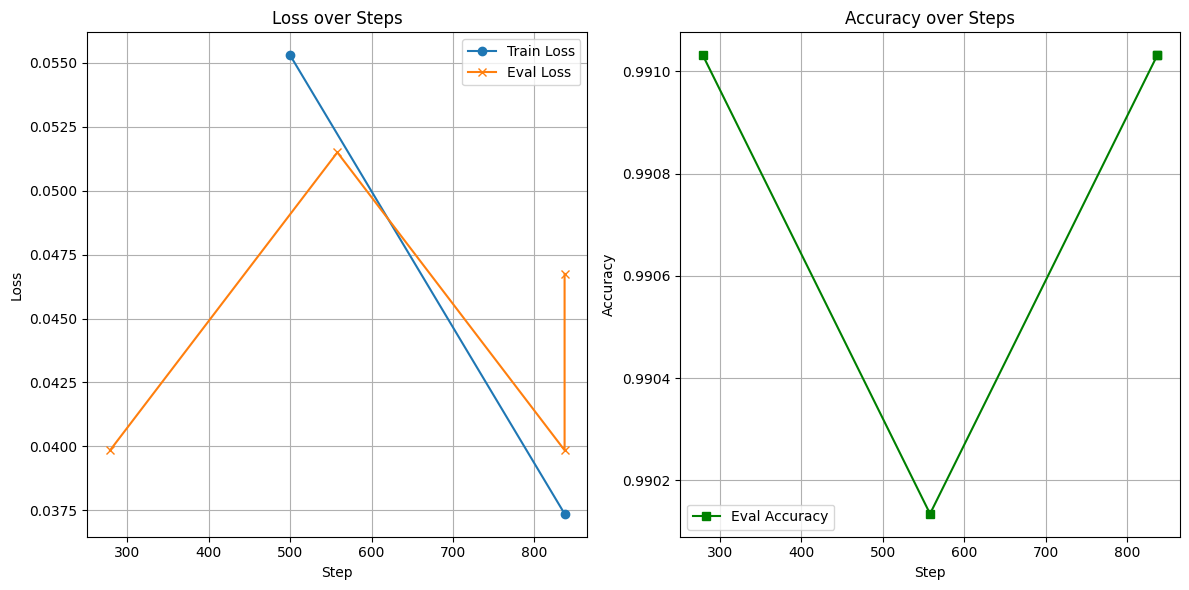

In [28]:
# Extract values
eval_losses = []
train_losses = []
accuracies = []

for entry in logs:
    step = entry.get('step')
    if 'eval_loss' in entry:
        eval_losses.append((step, entry['eval_loss']))
    if 'eval_accuracy' in entry:
        accuracies.append((step, entry['eval_accuracy']))
    if 'train_loss' in entry:
        train_losses.append((step, entry['train_loss']))
    if 'loss' in entry:
        train_losses.append((step, entry['loss']))

# Sort by step
eval_losses.sort()
train_losses.sort()
accuracies.sort()

# Split into x and y
eval_steps, eval_loss_vals = zip(*eval_losses)
train_steps, train_loss_vals = zip(*train_losses)
acc_steps, acc_vals = zip(*accuracies)

# Plotting
plt.figure(figsize=(12, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(train_steps, train_loss_vals, label='Train Loss', marker='o')
plt.plot(eval_steps, eval_loss_vals, label='Eval Loss', marker='x')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Loss over Steps')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(acc_steps, acc_vals, label='Eval Accuracy', marker='s', color='green')
plt.xlabel('Step')
plt.ylabel('Accuracy')
plt.title('Accuracy over Steps')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [18]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.039848,0.991031,0.965753
2,0.055300,0.051500,0.990135,0.962457
3,0.055300,0.046744,0.991031,0.965517


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


TrainOutput(global_step=837, training_loss=0.037360595830737336, metrics={'train_runtime': 111.1301, 'train_samples_per_second': 120.372, 'train_steps_per_second': 7.532, 'total_flos': 224107154909436.0, 'train_loss': 0.037360595830737336, 'epoch': 3.0})

In [19]:
trainer.evaluate(tokenized_dataset['test'])

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'eval_loss': 0.03984760120511055,
 'eval_accuracy': 0.9910313901345291,
 'eval_f1': 0.9657534246575343,
 'eval_runtime': 2.8897,
 'eval_samples_per_second': 385.848,
 'eval_steps_per_second': 24.224,
 'epoch': 3.0}